# Tutorial 9 (Observer)

This is a tutorial for E-Cell4. Here, we explain Observer classes for logging data during simulation.

In [1]:
from ecell4.core import *
from ecell4.gillespie import *

m = NetworkModel()
m.add_reaction_rule(create_unimolecular_reaction_rule(Species("A"), Species("B"), 1.0))
m.add_reaction_rule(create_unimolecular_reaction_rule(Species("B"), Species("A"), 0.5))
w = GillespieWorld(Real3(1, 1, 1))
w.add_molecules(Species("A"), 60)
s = GillespieSimulator(m, w)
s.initialize()

Prepare observers. Not necessarily needed to be created here.

In [2]:
obs1 = FixedIntervalNumberObserver(1.0, ["A"])
obs2 = NumberObserver(["A", "B"])
# obs3 = FixedIntervalHDF5Observer(5.0, "test%02d.h5")

Run simulation with observers.

In [3]:
s.run(16.0, [obs1, obs2])

NumberObservers return data by calling the member function `[FixedInterval]NumberObserver::data()`. `targets()` returns a list of species you gave in the constructor.

In [4]:
print(obs1.data())
print([sp.serial() for sp in obs1.targets()])

[[0.0, 60.0], [1.0, 33.0], [2.0, 19.0], [3.0, 19.0], [4.0, 23.0], [5.0, 22.0], [6.0, 26.0], [7.0, 20.0], [8.0, 18.0], [9.0, 20.0], [10.0, 18.0], [11.0, 20.0], [12.0, 25.0], [13.0, 25.0], [14.0, 18.0], [15.0, 18.0], [16.0, 23.0]]
['A']


`FixedIntervalHDF5Observer` saves a World as HDF5. `FixedIntervalHDF5Observer::filename()` returns the name of HDF5 scheduled to be saved next.

In [5]:
# print(obs3.filename())

Plot data in an Observer. `NumberObserver` logs data just after every step when any reactions occur.

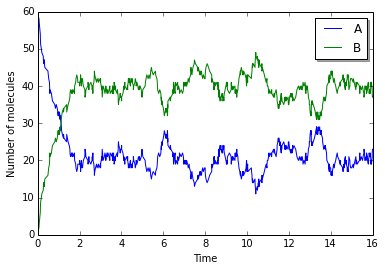

In [6]:
%matplotlib inline
import matplotlib.pylab as plt

labels = [sp.serial() for sp in obs2.targets()]
data = numpy.asarray(obs2.data()).T

for i in range(1, len(data)):
    plt.plot(data[0], data[i], label=labels[i - 1])
plt.xlabel("Time")
plt.ylabel("Number of molecules")
plt.legend(loc="best", shadow=True)
plt.show()

Check HDF5 files.

In [7]:
# import glob
# print(glob.glob("test*.h5"))
# w.load('test03.h5')
# print(w.t(), w.num_molecules(Species("A")), w.num_molecules(Species("B")))